# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
# # transforms
train_transforms = transforms.Compose([
                                         transforms.Resize(224),
                                        #transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std


test_transforms = transforms.Compose([
                                     transforms.Resize(224),
#                                       transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std

In [4]:
import torchvision
from torch.utils.data import DataLoader

In [5]:
federated_train_loader = DataLoader(
    torchvision.datasets.ImageFolder(root='/home/zhaojia-raoxy/data/idsUCTL/train_224',
                                     transform=train_transforms),
    batch_size=100,
    shuffle=True,**kwargs)


federated_test_loader = DataLoader(
    torchvision.datasets.ImageFolder(root='/home/zhaojia-raoxy/data/idsUCTL/test_224',
                                     transform=test_transforms),
    batch_size=100,
    shuffle=False,**kwargs)

# SimpleCNN

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
# 移动模型到GPU
model = SimpleCNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练

In [8]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)*1.0
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [9]:
loss_train=[]
acc_train=[]
def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
#         model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        n += target.shape[0]
        loss = criterion(output, target.long())
#         loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         model.get() # <-- NEW: get the model back
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print("{}\t{}".format(correct,target.shape))
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)*1.0
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
     100.*correct / n))

In [10]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=100)
    test(model, device, federated_test_loader, batch_size=100)

Train set: Average loss: 0.0713, Accuracy: 382848/196100 (98%)
Test set: Average loss: 0.1567, Accuracy: 90295/98100 (92%)
Train set: Average loss: 0.1263, Accuracy: 368996/196100 (94%)
Test set: Average loss: 0.0712, Accuracy: 94495/98100 (96%)
Train set: Average loss: 0.0920, Accuracy: 373797/196100 (95%)
Test set: Average loss: 0.0682, Accuracy: 94495/98100 (96%)
Train set: Average loss: 0.0913, Accuracy: 373788/196100 (95%)
Test set: Average loss: 0.0682, Accuracy: 94495/98100 (96%)
Train set: Average loss: 0.0911, Accuracy: 373794/196100 (95%)
Test set: Average loss: 0.0677, Accuracy: 94495/98100 (96%)
Train set: Average loss: 0.1350, Accuracy: 362428/196100 (92%)
Test set: Average loss: 0.1386, Accuracy: 90295/98100 (92%)


KeyboardInterrupt: 

# 结果保存

In [11]:
save_name='CNN_CarHacking_nfl'

In [27]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/idsUCTL/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/idsUCTL/{}.pt".format(save_name))

保存文件： /home/zhaojia-raoxy/model/idsUCTL/CNN_CarHacking_nfl.pt


In [28]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/idsUCTL/{}.pth".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/idsUCTL/{}.pth".format(save_name))

保存文件： /home/zhaojia-raoxy/model/idsUCTL/CNN_CarHacking_nfl.pth


/home/zhaojia-raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SimpleCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 分析

In [14]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [15]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/zhaojia-raoxy/files/{}".format(save_name),index=False)

In [16]:
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


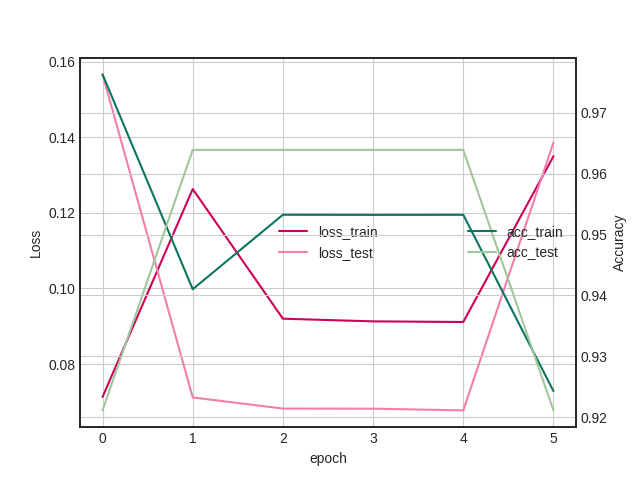

In [17]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()

## 模型预测

生成预测的配置文件

In [32]:
import os

verify_root='/home/zhaojia-raoxy/data/idsUCTL/test_224/' 
true_label_txt='/home/zhaojia-raoxy/files/idsUCTL/true_label_alexnet_yeo.txt'

def Create_data_dir_with_true_label(_root, save_name):
    ''':cvar保存每一张图片的地址+对应的正确的标签'''
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + str(_img.split('/')[-2]) + '\n')
    print("生成文件成功：",save_name)
    
Create_data_dir_with_true_label(verify_root, true_label_txt)

生成文件成功： /home/zhaojia-raoxy/files/idsUCTL/true_label_alexnet_yeo.txt


In [33]:
verify_root='/home/zhaojia-raoxy/data/idsUCTL/test_224/'
predicted_label_txt='/home/zhaojia-raoxy/files/idsUCTL/predicted_label_alexnet_yeo.txt'

def Create_data_dir_with_no_label(_root, save_name):
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    # print(_list)
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + "0" + '\n')
    print("生成文件成功：",save_name)
    
Create_data_dir_with_no_label(verify_root, predicted_label_txt)    

生成文件成功： /home/zhaojia-raoxy/files/idsUCTL/predicted_label_alexnet_yeo.txt


## 加载模型

In [34]:
import torch
save_name='CNN_CarHacking_nfl'
# 加载整个模型
model = torch.load("/home/zhaojia-raoxy/model/idsUCTL/{}.pth".format(save_name))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 预测

In [35]:
from utils import LoadData, write_result
from torch.utils.data import DataLoader
def eval(dataloader, model):
    label_list = []
    likelihood_list = []
    pred_list = []
    model.eval()
    with torch.no_grad():
        # 加载数据加载器，得到里面的X（图片数据）和y(真实标签）
        for idx, (X, y) in enumerate(dataloader):
            # 将图片传入到模型当中就，得到预测的值pred
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_softmax = torch.softmax(pred, 1).cpu().numpy()
            # 获取可能性最大的标签
            label = torch.softmax(pred, 1).cpu().numpy().argmax()
            label_list.append(label)
            # 获取可能性最大的值（即概率）
            likelihood = torch.softmax(pred, 1).cpu().numpy().max()
            likelihood_list.append(likelihood)
            pred_list.append(pred_softmax.tolist()[0])

    return label_list, likelihood_list, pred_list

valid_data = LoadData(true_label_txt  , train_flag=False)
_dataloader = DataLoader(dataset=valid_data, num_workers=4, pin_memory=True, batch_size=1)

In [36]:
label_list, likelihood_list, pred = eval(_dataloader, model)

## 将输出保存到exel中

In [37]:
save_name = 'CNN_CarHacking_nfl_pre'

In [38]:
import pandas as pd
label_names = ['R', 'RPM', 'gear', 'DoS', 'Fuzzy']
df = pd.DataFrame(data=pred, columns=label_names)
df.to_csv('/home/zhaojia-raoxy/files/idsUCTL/{}.csv'.format(save_name), encoding='utf-8', index=False)
print('执行完毕，生成文件：/home/zhaojia-raoxy/files/idsUCTL/{}.csv'.format(save_name))

执行完毕，生成文件：/home/zhaojia-raoxy/files/idsUCTL/CNN_CarHacking_nfl_pre.csv


## 绘图

In [39]:
target_data = pd.read_csv(true_label_txt, sep="\t", names=["loc", "type"])
true_label = [i for i in target_data["type"]]

In [40]:
save_name =  'CNN_CarHacking_nfl_pre'

In [41]:
predict_loc ='/home/zhaojia-raoxy/files/idsUCTL/{}.csv'.format(save_name)    # 3.ModelEvaluate.py生成的文件
predict_data = pd.read_csv(predict_loc)#,index_col=0)
predict_label = predict_data.to_numpy().argmax(axis=1)
predict_score = predict_data.to_numpy().max(axis=1)
# # 精度，准确率， 预测正确的占所有样本种的比例
print(len(predict_label))

98031


## 验证集-精度

In [42]:
from sklearn.metrics import accuracy_score  # pip install scikit-learn
accuracy = accuracy_score(true_label, predict_label)
print("精度: ",accuracy)

精度:  0.9210861870224725


## 验证集-查准率P（准确率）

precision(查准率)=TP/(TP+FP)

In [43]:
from sklearn.metrics import precision_score
precision = precision_score(true_label, predict_label, labels=None, pos_label=1, average='macro') # 'micro', 'macro', 'weighted'
print("查准率P: ",precision)

查准率P:  0.47479161608804726


/home/zhaojia-raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 验证集-查全率R（召回率）

原本为对的，预测正确的比例；recall(查全率)=TP/(TP+FN)

In [44]:
from sklearn.metrics import recall_score
recall = recall_score(true_label, predict_label, average='macro') # 'micro', 'macro', 'weighted'
print("召回率: ",recall)

召回率:  0.6


## 验证集-F1-Score

In [45]:
from sklearn.metrics import f1_score

f1 = f1_score(true_label, predict_label, average='macro')     # 'micro', 'macro', 'weighted'
print("F1 Score: ",f1)

F1 Score:  0.5088703027447286


## 验证集合-混淆矩阵

In [46]:
_fig_title='CNN_CarHacking_nfl_pre'

<IPython.core.display.Javascript object>


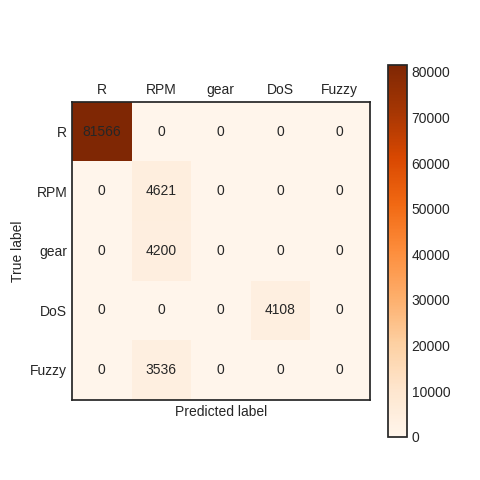

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
# plt.figure(figsize=(15, 15))
label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
confusion = confusion_matrix(true_label, predict_label, labels=[i for i in range(len(label_names))])
plt.matshow(confusion, cmap=plt.cm.Oranges)   # Greens, Blues, Oranges, Reds
plt.colorbar()
for i in range(len(confusion)):
    for j in range(len(confusion)):
        plt.annotate(confusion[j,i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(label_names)), label_names)
plt.yticks(range(len(label_names)), label_names)
# plt.title("{} Confusion Matrix".format(_fig_title))
plt.show()
# plt.savefig('/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title),bbox_inches="tight")
# print('执行完毕，生成文件：/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title))

## 验证集-ROC曲线

In [48]:
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
n_classes = len(label_names)
# binarize_predict = label_binarize(predict_label, classes=[i for i in range(n_classes)])
binarize_predict = label_binarize(true_label, classes=[i for i in range(n_classes)])
# 读取预测结果
predict_score = predict_data.to_numpy()
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarize_predict[:,i], [socre_i[i] for socre_i in predict_score])
    roc_auc[i] = auc(fpr[i], tpr[i])
print("roc_auc = ",roc_auc)

roc_auc =  {0: 1.0, 1: 0.9585911572636763, 2: 0.9565335550084727, 3: 1.0, 4: 0.9533255727816287}


## 验证集-AUC曲线

<IPython.core.display.Javascript object>


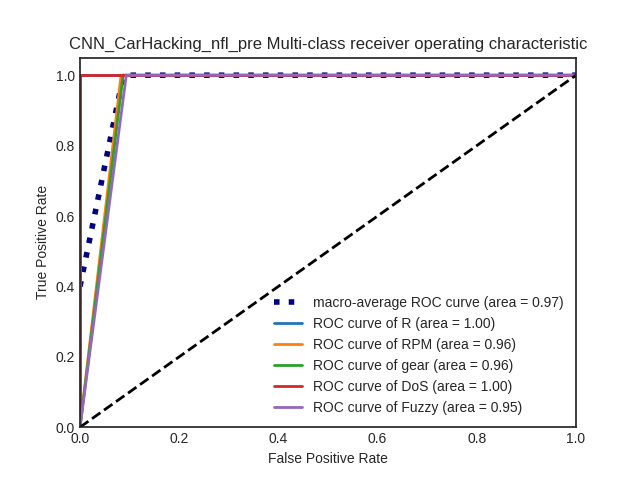

In [49]:
from numpy import interp
import numpy as np

_fig_title='CNN_CarHacking_nfl_pre'

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} Multi-class receiver operating characteristic'.format(_fig_title))
plt.legend(loc="lower right")
plt.show()
# plt.savefig('../img/{}_roc_fig.png'.format(args._fig_title),bbox_inches="tight")
# print('执行完毕生成文件：../img/{}_roc_fig.png'.format(_fig_title))